In [1]:
corpus = ['the woman is a wise queen',
          'the man is a wise president',
          'she is a pretty woman',
          'he is a strong man',
          'she is still young',
          'he is very old',
          'he is the current president of US',
          'the prince is a son of the king',
          'the princess is a daughter of the king',
          'a prince is a young man',
          'a princess is a young woman']

In [2]:
# function for generating label for each word using Skip Gram with window size 2
def data_generation_SkipGram(corpus):    
    sentences = []
    for sentence in corpus:
        sentences.append(sentence.split())

    window_size = 2 # window size

    data = []
    for sentence in sentences:
        for idx, word in enumerate(sentence):
            for neighbor in sentence[max(idx - window_size, 0) : min(idx + window_size, len(sentence)) + 1] : 
                if neighbor != word:
                    data.append([word, neighbor])
    return data

In [4]:
import pandas as pd

data = data_generation_SkipGram(corpus)
df = pd.DataFrame(data, columns = ['input', 'label'])

In [5]:
df.head(10)

,input,label
0,the,woman
1,the,is
2,woman,the
3,woman,is
4,woman,a
5,is,the
6,is,woman
7,is,a
8,is,wise
9,a,woman


In [6]:
df.shape

(194, 2)

In [7]:
# function for making word set by which we will have word vectors
def make_word_set(corpus):
    words = []
    for text in corpus:
        for word in text.split(' '):
            words.append(word)
    words = set(words)
    return words

In [8]:
words = make_word_set(corpus)

In [9]:
# function for mapping, word2int
def make_word2int(words):
    word2int = {}
    for i,word in enumerate(words):
        word2int[word] = i
    return word2int

In [10]:
d = make_word2int(words)

In [11]:
import numpy as np

# function for one hot encoding
def to_one_hot_encoding(word_index, ONE_HOT_DIM):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[word_index] = 1
    return one_hot_encoding

In [ ]:
# Skip Gram
# cross entropy 참고
# https://ratsgo.github.io/deep%20learning/2017/10/02/softmax/
# https://kevinthegrey.tistory.com/123

In [12]:
import tensorflow as tf

ONE_HOT_DIM = len(words)

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(d[x], ONE_HOT_DIM))
    Y.append(to_one_hot_encoding(d[y], ONE_HOT_DIM))

# convert X,Y to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# embedding dimension
EMBEDDING_DIM = 2

# hidden layer : represent word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1]))
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
output = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function : cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(output), axis=[1]))

# training
train = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

/Users/yunho/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 10000
for i in range(iteration):
    # input : X_train which is one hot encoded word
    # label : Y_train which is one hot encoded neighbor word
    sess.run(train, feed_dict={x: X_train, y_label: Y_train})
    if i % 2000 == 0:
        print('iteration '+ str(i) +' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  4.2121353
iteration 2000 loss is :  2.5424113
iteration 4000 loss is :  2.4533038
iteration 6000 loss is :  2.4175515
iteration 8000 loss is :  2.3984363


In [14]:
# the hidden layer (W1 + b1) -> look up table
vectors = sess.run(W1 + b1)
vectors

array([[-1.2776256 , -1.1218485 ],
       [-1.2781937 , -0.52006   ],
       [-1.0344881 , -0.97765744],
       [-1.5187458 , -0.95980227],
       [-0.4044921 , -0.00772554],
       [-1.513166  , -0.9557623 ],
       [-0.12154484, -0.8883838 ],
       [ 0.75246775, -1.1059029 ],
       [-0.34483933, -1.0877048 ],
       [ 0.87388885, -0.989466  ],
       [-1.2735721 , -0.515584  ],
       [-1.3930722 , -1.150423  ],
       [-2.5167203 , -1.5212427 ],
       [-1.1088531 , -0.95625544],
       [-0.52910227,  0.8708569 ],
       [-0.5765387 ,  0.32309735],
       [-1.1204214 , -0.962742  ],
       [-2.5764651 , -1.5608743 ],
       [-0.9386195 ,  0.08079338],
       [-1.0694305 , -0.39312938],
       [-0.94867766, -0.69716656],
       [-0.8352793 , -0.679888  ],
       [-0.55130124,  2.977857  ],
       [ 0.72122145, -0.9909807 ]], dtype=float32)

In [15]:
sess.close()

In [16]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,she,-1.277626,-1.121848
1,woman,-1.278194,-0.520060
2,young,-1.034488,-0.977657
3,son,-1.518746,-0.959802
4,US,-0.404492,-0.007726
5,daughter,-1.513166,-0.955762
6,still,-0.121545,-0.888384
7,a,0.752468,-1.105903
8,old,-0.344839,-1.087705
9,the,0.873889,-0.989466


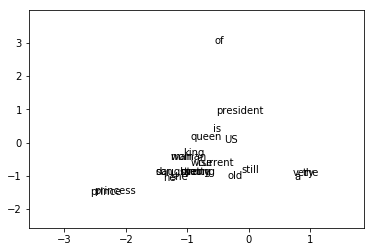

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x1_axis_min = np.amin(vectors, axis=0)[0] - PADDING
x2_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x1_axis_max = np.amax(vectors, axis=0)[0] + PADDING
x2_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x1_axis_min,x1_axis_max)
plt.ylim(x2_axis_min,x2_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()